<a href="https://colab.research.google.com/github/ad709kr/NYC-Taxi-Trip-Time-Predction/blob/main/NYC_trip_time_prediction_individual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Name    -  NYC Taxi Trip Time Prediction 

## Project Summary 
Task  is to build model to predicts the total ride duration of taxi trip in the New York city.Your primary dataset is one released by NYC Taxi and Limousine commission, which includes pickup time, geo-coordinates, number of passengers, and total other variables.

## Problem statement
Given the dataset, we have to predict the taxi trip duration.

## Dataset description  
**id** - a unique identifier for each trip
<br>**vendor_id** - a code indicating the provider associated with the trip record
<br>**pickup_datetime** - date and time when the meter was engaged
<br>**dropoff_datetime** - date and time when the meter was disengaged
<br>**passenger_count** - the number of passengers in the vehicle (driver entered value)
<br>**pickup_longitude** - the longitude where the meter was engaged
<br>**pickup_latitude** - the latitude where the meter was engaged
<br>**dropoff_longitude** - the longitude where the meter was disengaged
<br>**dropoff_latitude** - the latitude where the meter was disengaged
<br>**store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward 
<br>**trip_duration** - duration of the trip in seconds




## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file = '/content/drive/MyDrive/Almabetter/regression_project/Copy of NYC Taxi Data.csv'
df = pd.read_csv(file)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
print("The shape of dataset is ",df.shape)

The shape of dataset is  (1458644, 11)


In [5]:
# Checking null values
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:
# checking duplicate
df[df.duplicated()].count()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

**observation**
<br> There is no null, duplicate items in the dataset. Two features which needs to be converted in to the date_time function and to extract some features from that.

In [8]:
# Lets convert pickup_datetime and drop_off datetime to datetime functions
df['pickup_datetime'] = pd.to_datetime(df["pickup_datetime"])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])
#df = pd.to_datetime(df["dropoff_datetime"])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [10]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


**Feature engineering**


In [11]:
# date_time to day
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()

In [12]:
# date_time to month
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

## Exploratory data analysis

In [13]:
# list of the columns
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'pickup_month',
       'dropoff_month'],
      dtype='object')

In [14]:
# Counting the unique value of each feature
df['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [15]:
df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [16]:
df['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

originally 3 catogorical feature are present i.e., vendor_id, passenger_count, store_and_fwd_flag and we add 4 more categorical feature from date_time feature.

**Univariate analysis**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


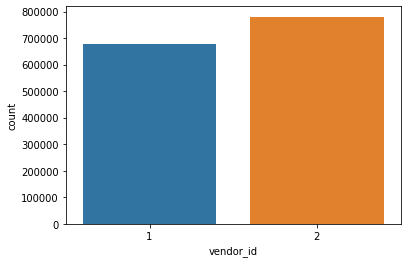

In [17]:
# vendor_id
sns.countplot(df['vendor_id'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


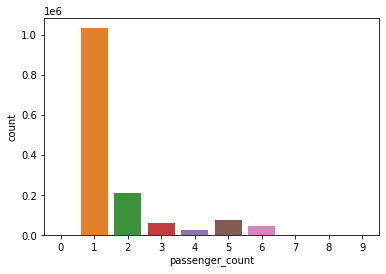

In [18]:
# passenger_count
sns.countplot(df['passenger_count'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


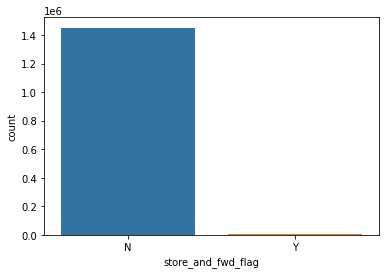

In [19]:
#store_and_fwd_flag
sns.countplot(df['store_and_fwd_flag'])

**Observation**
<br> vendor_ id 2 has provided more trips than the vendor_id 1
<br> For a trip, most of the time only one passenger were travelled however in one case 8 and 9 passenger have also travelled through a taxi.
<br> only 8045 data have been stored in local memory and then sent to server however rest were directly sharing data to the server.

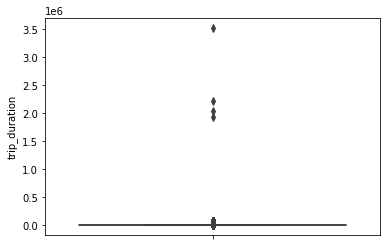

In [25]:
# Trip duration
sns.boxplot(data = df, y = 'trip_duration')

In [28]:
count = 0
count2 = 0
for val in df['trip_duration']:
  if val > 10**6:
    count += 1
  if val < 60:
    count2 += 1
print(count)
print(count2)

4
8595


<br> 4 outliers present in the dataset as we can see that these 4 trip_duration are very large compared to other values.
<br> however there 8595 rides where trip duration is less than a minute.

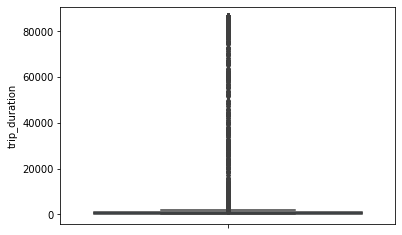

In [37]:
### After removing these outlier lets see the nature of the plot
lst_ = []
for i in range(df.shape[0]):
  if df['trip_duration'].iloc[i] > 10**6:
    lst_.append(i)
df.drop(axis = 0, index = lst_, inplace = True)
sns.boxplot(data = df, y = 'trip_duration')
    


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


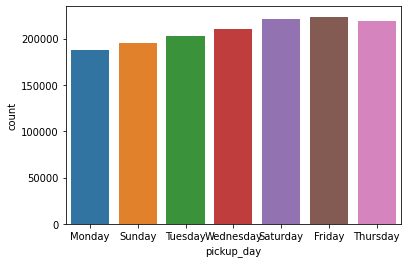

In [38]:
# pickup day
sns.countplot(df['pickup_day'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


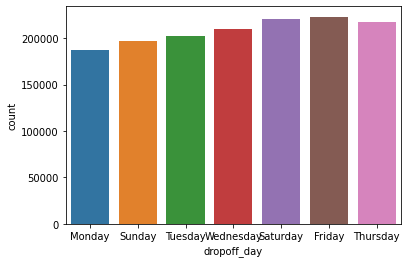

In [39]:
sns.countplot(df['dropoff_day'])

<br> both  the graph are similar, friday and saturday have maximum number of trips.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


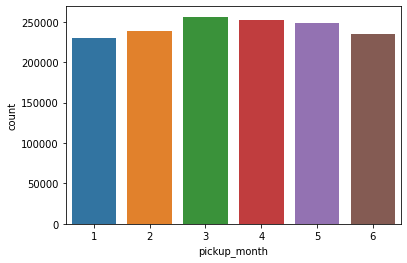

In [40]:
sns.countplot(df['pickup_month'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


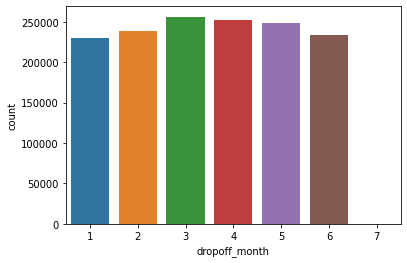

In [41]:
sns.countplot(df['dropoff_month'])

<br> pickup and dropoff month both have similar graph.

**Bivariate analysis**

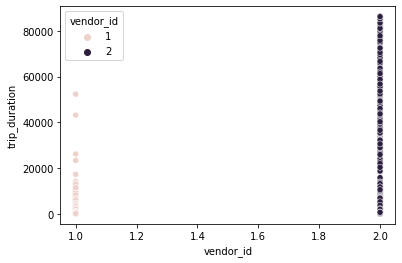

In [48]:
# vendor_id vs trip duration
sns.scatterplot(data = df, x = 'vendor_id', y ='trip_duration', hue='vendor_id')


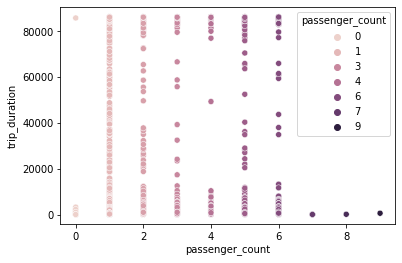

In [49]:
sns.scatterplot(data = df, x = 'passenger_count', y ='trip_duration', hue='passenger_count')


<br> 60 trip have zero pessanger count, 1 trip have 7,8 and 9 passenger counts.


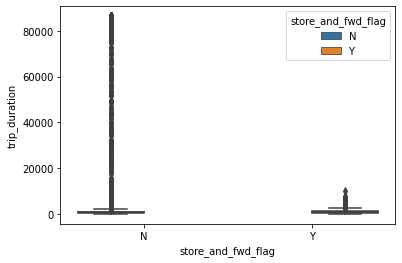

In [51]:
sns.boxplot(data = df, x = 'store_and_fwd_flag', y ='trip_duration', hue='store_and_fwd_flag')

**Multivariate analysis**

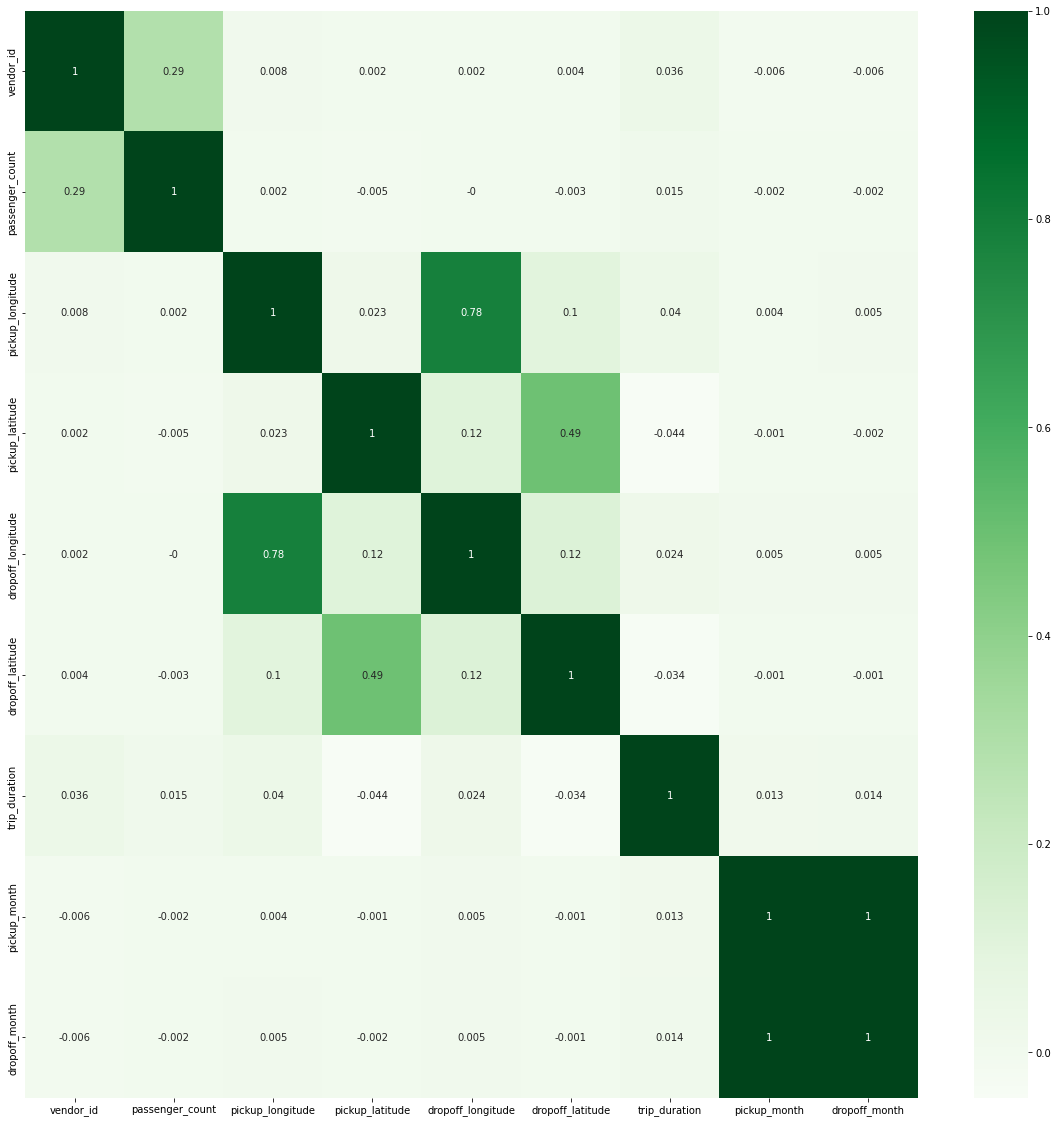

In [53]:
corr = round(df.corr(),3)
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap="Greens",annot=True)
